In [36]:
# importando as bibliotecas

import numpy as np
import sympy as sym
import control as ct
import matplotlib.pyplot as plt
from scipy.signal import lsim

plt.style.use('_mpl-gallery')

In [178]:
# Parâmetros do sistema
m = 1 # Massa pêndulo
M = 5 # Massa carro
L = 2 # Comprimento haste
g = -10 # Aceleração da gravidade
d = 1  # Coef.Amortc
s = -1


# Criando as matrizes de espaço de estado
A = np.array([[0,1,0,0],[0,-d/M,-m*g/M,0],[0,0,0,1],
              [0,-s*d/(M*L), -s*(m+M)*g/(M*L),0]])
B = np.array([[0],[1/M],[0],[s*1/(M*L)]])
C = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
D = 0

In [120]:
# Definindo o sistema
sys = ct.ss(A,B,C,D)
print(sys)

<StateSpace>: sys[25]
Inputs (1): ['u[0]']
Outputs (4): ['y[0]', 'y[1]', 'y[2]', 'y[3]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[ 0.   1.   0.   0. ]
     [ 0.  -0.2  2.   0. ]
     [ 0.   0.   0.   1. ]
     [ 0.   0.1 -6.   0. ]]

B = [[ 0. ]
     [ 0.2]
     [ 0. ]
     [-0.1]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]

D = [[0.]
     [0.]
     [0.]
     [0.]]



(array([ 0.        +0.j        , -0.16682056+0.j        ,
        -0.01658972+2.44830345j, -0.01658972-2.44830345j]),
 array([], dtype=float64))

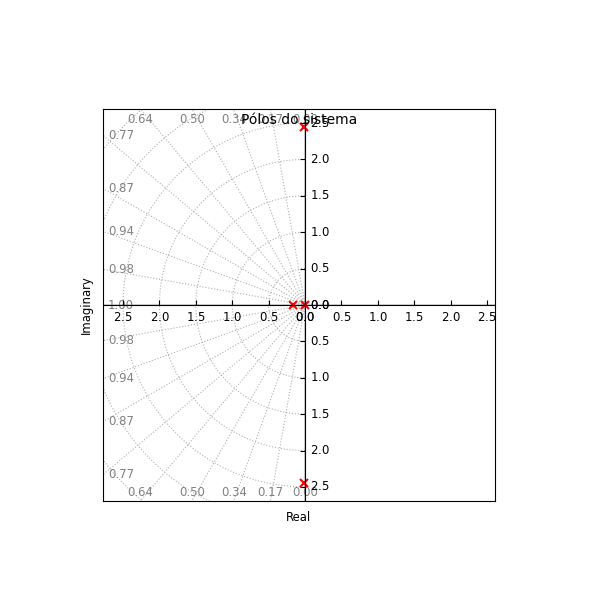

In [121]:
# Pólos do sistema

plt.figure(figsize=(4, 4)) 
ct.pzmap(sys,plot=True,title ='Pólos do sistema',grid=True,marker_color='r')


In [123]:
#plt.figure(figsize=(4, 4)) 
#ct.root_locus(sys,title ='LGR do sistema',grid=True,marker_color='r',ylim=[-3,3])

In [124]:
# Plotar resposta inicial do sistema em malha aberta
dt = 0.01
x0 = np.array([[0.0],[0.0],[0.0],[0]])
tp = np.arange(0, 5, dt) 
u0 = np.ones_like(tp)
#t,y = ct.initial_response(sys, tp,x0) # Resposta Inicial
t,y = ct.forced_response(sys, tp,u0,x0) # Resposta Inicial
r,p = ct.step_response(sys,tp,x0) # Resposta ao degrau

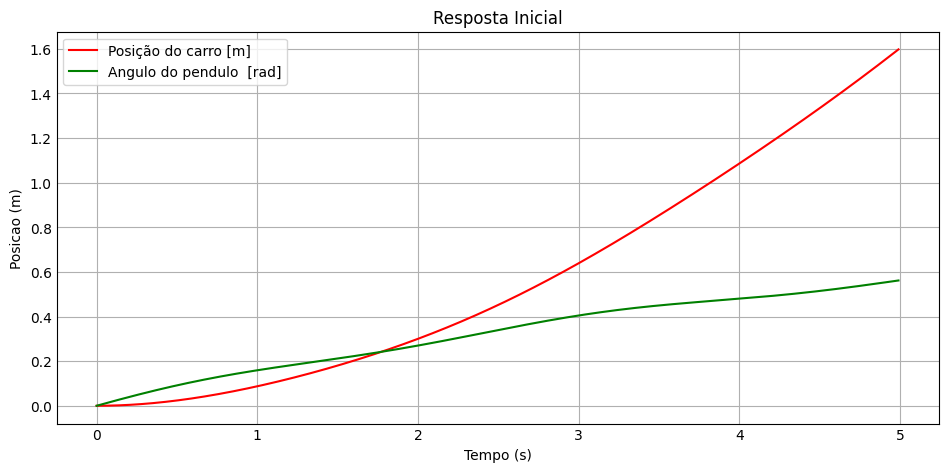

In [127]:
altura = 4
largura = 9

#plt.style.use(['science','seaborn-v0_8-whitegrid'])
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t,y[0], '-r',label='Posição do carro [m]')
subplots[1].plot(t,y[1], '-g',label='Angulo do pendulo  [rad]')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posicao (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()



# LQR

In [172]:
Q = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
R = 0.01
K,S,E = ct.lqr(sys,Q,R)

#controlador Lqr
A_lqr = A - B*K
B_lqr = B
C_lqr = C
D_lqr = D
sys_mf_lqr = ct.ss(A_lqr, B_lqr, C_lqr, D_lqr)

In [173]:
# Tempo de simulação
t_lqr = np.arange(0,10,dt)


# Definindo entrada
u_lqr = np.zeros_like(t_lqr)

# Atribuindo valores ao array u
u_lqr[99:120] =  0 # Impulso positivo
u_lqr[499:] = 1  # Impulso negativo
# Condições iniciais:
x0_lqr = np.array([[0],[0],[0],[0]])

# Resposta do sistema
t_lqr,y_lqr = ct.forced_response(sys_mf_lqr,t_lqr,u_lqr,x0_lqr)
#t_lqr,y_lqr = ct.initial_response(sys_mf_lqr,t_lqr,x0_lqr)
 

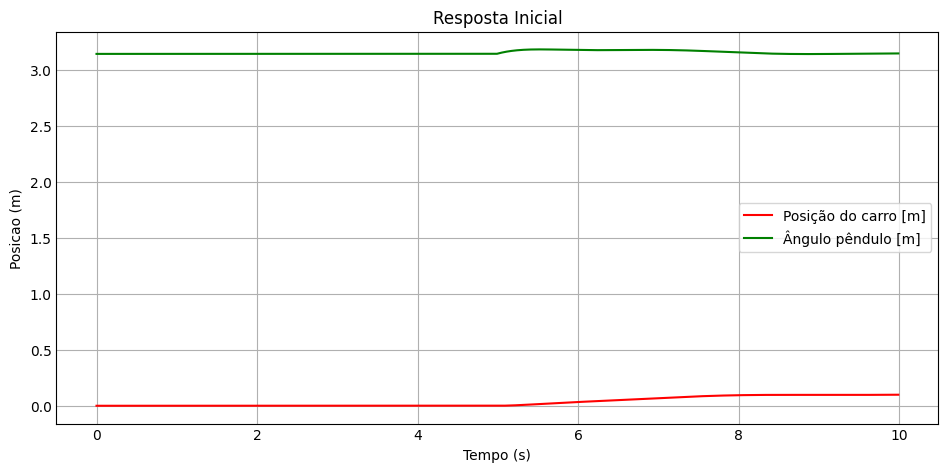

In [174]:
# + np.ones_like(t_lqr) = estabiliza em 1 em vez de 0 

subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t_lqr,y_lqr[0], '-r',label='Posição do carro [m]')
subplots[1].plot(t_lqr,y_lqr[1]+ np.pi, '-g',label='Ângulo pêndulo [m]')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posicao (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()

# Filtro de  KALMAN

In [176]:
# Sistema aumentado com pertubações e ruidos

Vd = 0.01*np.eye(4) # covariância de pertubação
Vn = 1 # covariância de ruido


In [183]:
#Entradas aumentadas com pertubação e ruido
Bf = np.hstack((B, Vd, np.zeros_like(B))) 
Ck = np.array([[1,0,0,0]])
# Cria um grande sistema em espaço de estados com uma entrada simples
sysC = ct.ss(A, Bf, C, np.array([0,0,0,0,0, Vn]))

# Sistema com todas as saidas de estado, pertubações e sem ruido
SysFullOutput = ct.ss(A,Bf, np.eye(4),np.zeros([4,np.size(Bf,1)]))

In [195]:
# Criando um Filtro de Kalman

# Design do Filtro
[L,P,Ek] = ct.lqe(A,Vd,Ck,Vd,Vn)

# Alternativamente, possivel construir usando "ct.lqr"
Kf,_,_= ct.lqr(np.transpose(A),np.transpose(Ck),Vd,Vn)
K_lqr=np.transpose([Kf[0]])

# Estimador Filtro de Kalman
sysKF = ct.ss(A - L * Ck,np.hstack((B,L)), np.eye(4),0 )



In [233]:
sysKF 

StateSpace(array([[-6.29000113e-03,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.92820571e-05, -2.00000000e-01,  2.00000000e+00,
         0.00000000e+00],
       [ 5.51046581e-06,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 1.28461650e-06,  1.00000000e-01, -6.00000000e+00,
         0.00000000e+00]]), array([[ 0.00000000e+00,  6.29000113e-03],
       [ 2.00000000e-01,  1.92820571e-05],
       [ 0.00000000e+00, -5.51046581e-06],
       [-1.00000000e-01, -1.28461650e-06]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]))

In [236]:
sysKF.A

array([[-6.29000113e-03,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.92820571e-05, -2.00000000e-01,  2.00000000e+00,
         0.00000000e+00],
       [ 5.51046581e-06,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 1.28461650e-06,  1.00000000e-01, -6.00000000e+00,
         0.00000000e+00]])

In [196]:
# Sistema linearizado estimado na posiçao "caida" 
dt = 0.01
t = np.arange(0,50,dt)

uDIST = np.random.randn(4, len(t))
uNOISE = np.random.randn(len(t))

u = np.zeros_like(t)

# Atribuindo valores ao array u
u[99:120] = 100  # Impulso positivo
u[1499:1520] = -100  # Impulso negativo

uAUG = np.vstack((u,Vd @ Vd @ uDIST,uNOISE))



In [197]:

t,y = ct.forced_response(sysC,t,uAUG)
u_entrada = np.vstack((u, np.transpose(y[0])))

t,xtrue = ct.forced_response(SysFullOutput,t,uAUG)

t,x = ct.forced_response(sysKF,t,u_entrada)


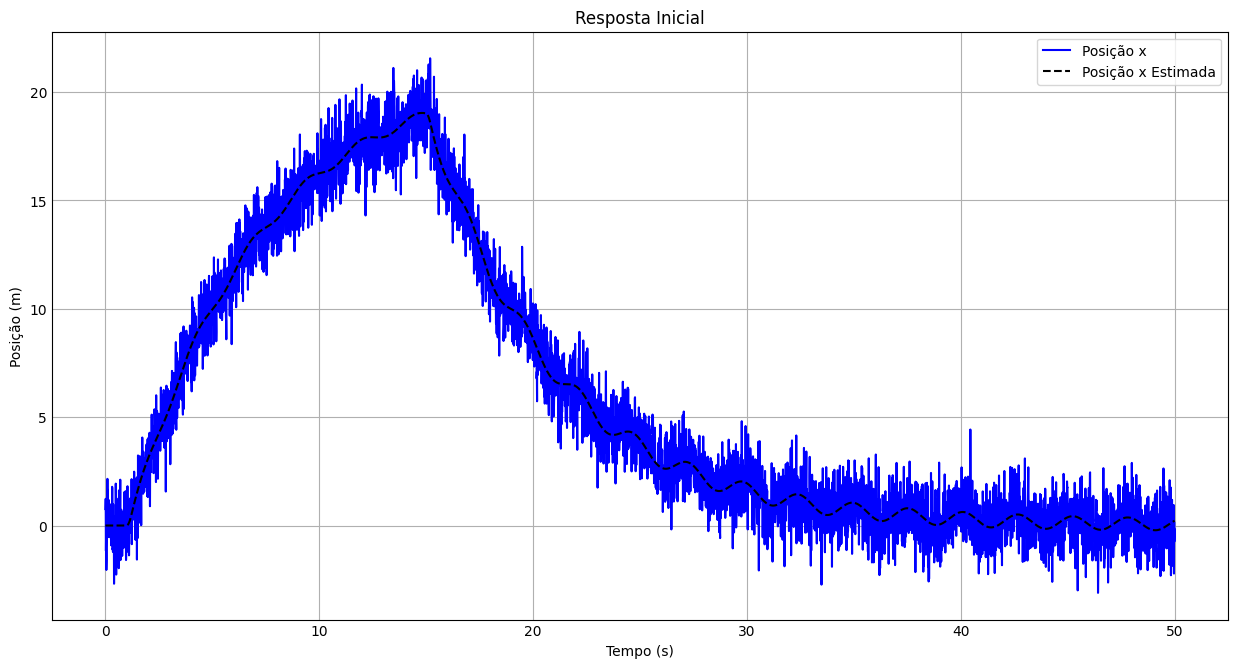

In [198]:
subplots = plt.subplots(1, 1, figsize=(12, 6))
subplots[1].plot(t,y[0],'b', label='Posição x')
#subplots[1].plot(t,xtrue[0],'-r', label='Posição x verdadeira')
subplots[1].plot(t,x[0],'--k', label='Posição x Estimada')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()

plt.show()

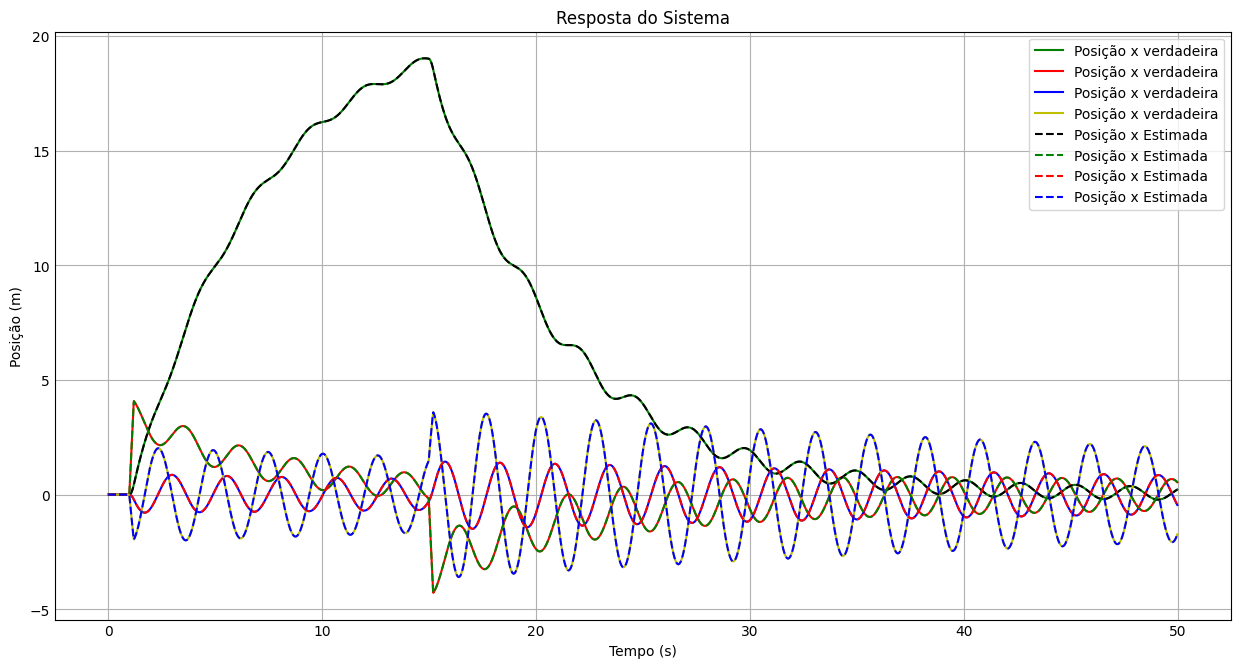

In [199]:
subplots = plt.subplots(1, 1, figsize=(12, 6))
subplots[1].plot(t,xtrue[0],'-g', label='Posição x verdadeira')
subplots[1].plot(t,xtrue[1],'-r', label='Posição x verdadeira')
subplots[1].plot(t,xtrue[2],'-b', label='Posição x verdadeira')
subplots[1].plot(t,xtrue[3],'-y', label='Posição x verdadeira')
subplots[1].plot(t,x[0],'--k', label='Posição x Estimada')
subplots[1].plot(t,x[1],'--g', label='Posição x Estimada')
subplots[1].plot(t,x[2],'--r', label='Posição x Estimada')
subplots[1].plot(t,x[3],'--b', label='Posição x Estimada')
subplots[1].set_title('Resposta do Sistema')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()

plt.show()

# LQG 


In [250]:
# Matrizes de peso LQR

Q = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
R = np.array([[0.0001, 0], [0, 0.0001]])
#K,_,_= ct.lqr(A,B,Q,R)

In [251]:
K_lqg,S_lqg,E_lqg = ct.lqr(sysKF.A,sysKF.B,Q,R)


[[  76.79479868  118.00392325 -229.69027945   -2.08780365]
 [  63.05902666   13.76219963    7.72798579   22.65856815]]


In [253]:
A_lqg = sysKF.A - sysKF.B@K_lqg
B_lqg = sysKF.B
C_lqg = sysKF.C
D_lqg = sysKF.D
sys_mf_lqg = ct.ss(A_lqg, B_lqg, C_lqg, D_lqg)

In [255]:
# Tempo de simulação
t_lqg = np.arange(0,50,dt)

# Definindo entrada
u_lqg = np.zeros_like(t_lqg)

# Atribuindo valores ao array u
u_lqg[4999:] = 1  # Impulso negativo

# Condições iniciais:
x0_lqg = np.array([[0],[0],[0],[0]])

# Resposta do sistema
#t_lqg,y_lqg = ct.forced_response(sys_mf_lqg,t_lqg,u_lqg,x0_lqg)
t_lqg,y_lqg = ct.step_response(sys_mf_lqg,t_lqg,x0_lqg)

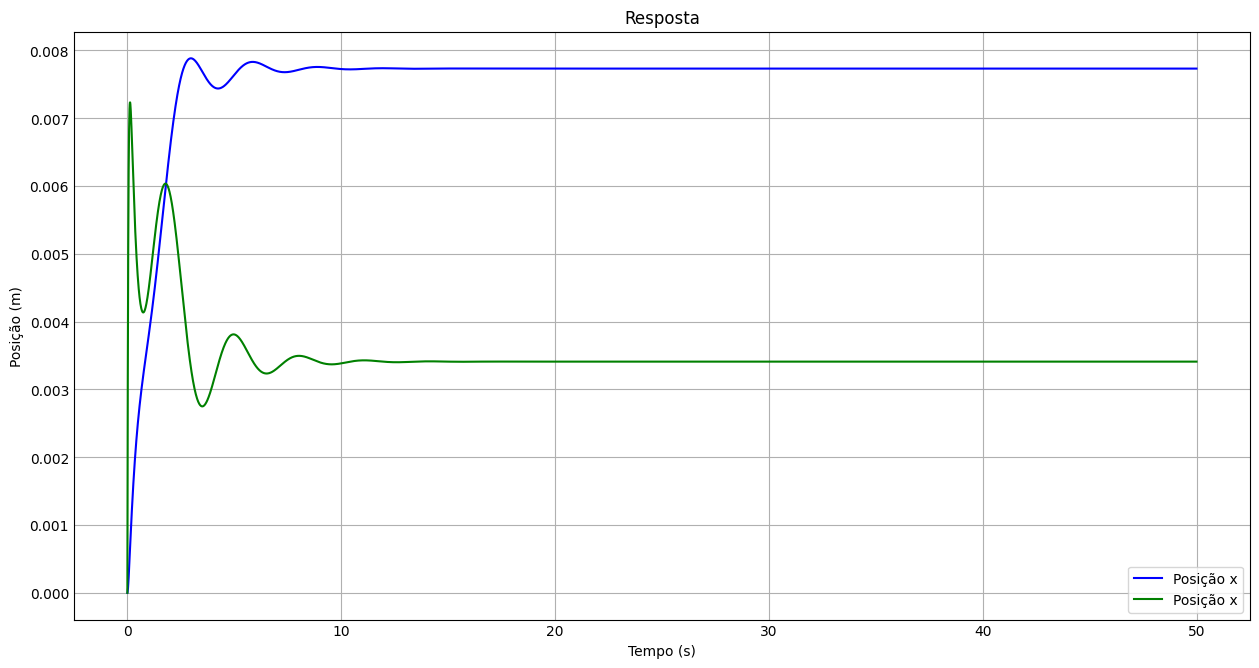

In [259]:
subplots = plt.subplots(1, 1, figsize=(12, 6))
subplots[1].plot(t_lqg,y_lqg[0][0],'b', label='Posição x')
subplots[1].plot(t_lqg,y_lqg[1][0],'g', label='Posição x')
subplots[1].set_title('Resposta')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()

plt.show()